In [ ]:
# Get your data from Canvas or find it here
#https://anindya-saha.github.io/blog/data-science-with-spark/retail-database-analysis-python/retail-database-analysis-python.html
# For example, https://github.com/anindya-saha/Data-Science-with-Spark/tree/master/retail-db-advanced-sql-analysis/data e.g. https://raw.githubusercontent.com/anindya-saha/Data-Science-with-Spark/master/retail-db-advanced-sql-analysis/data/customers.cs

# **`M7 - Part III of III`** **`->`** **`Apache Spark`**

## Exercise

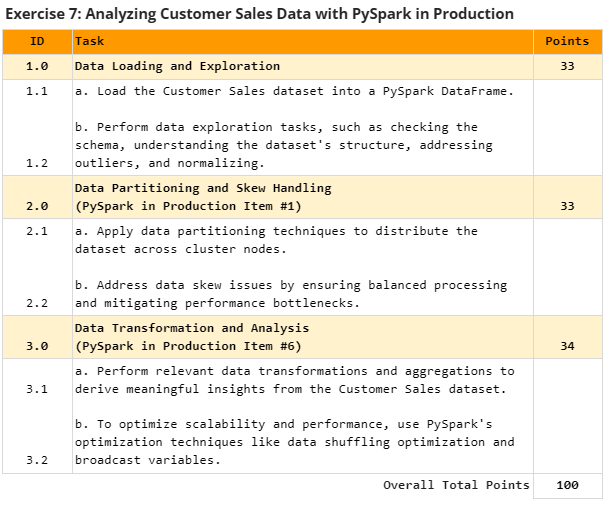

In [6]:
# 1.1 Load Customer Sales Data into PySpark Dataframne
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("CustomerSalesData").getOrCreate()

# Load CSV from local file with proper delimiter
df = spark.read.option("delimiter", ",") \
               .option("inferSchema", True) \
               .option("header", False) \
               .csv("customers.csv")

# Show the number of columns
print("Number of columns:", len(df.columns))
df.show(5, truncate=False)

Number of columns: 9
+---+-------+---------+---------+---------+-----------------------+-----------+---+-----+
|_c0|_c1    |_c2      |_c3      |_c4      |_c5                    |_c6        |_c7|_c8  |
+---+-------+---------+---------+---------+-----------------------+-----------+---+-----+
|1  |Richard|Hernandez|XXXXXXXXX|XXXXXXXXX|6303 Heather Plaza     |Brownsville|TX |78521|
|2  |Mary   |Barrett  |XXXXXXXXX|XXXXXXXXX|9526 Noble Embers Ridge|Littleton  |CO |80126|
|3  |Ann    |Smith    |XXXXXXXXX|XXXXXXXXX|3422 Blue Pioneer Bend |Caguas     |PR |725  |
|4  |Mary   |Jones    |XXXXXXXXX|XXXXXXXXX|8324 Little Common     |San Marcos |CA |92069|
|5  |Robert |Hudson   |XXXXXXXXX|XXXXXXXXX|10 Crystal River Mall  |Caguas     |PR |725  |
+---+-------+---------+---------+---------+-----------------------+-----------+---+-----+
only showing top 5 rows


In [8]:
# 1.2 Perform data exploration tasks

#Check Schema
df = df.toDF("customer_id", "customer_fname", "customer_lname",
             "customer_email", "customer_password", "customer_street",
             "customer_city", "customer_state", "customer_zipcode")

df.printSchema()
df.show(5, truncate=False)

root
 |-- customer_id: integer (nullable = true)
 |-- customer_fname: string (nullable = true)
 |-- customer_lname: string (nullable = true)
 |-- customer_email: string (nullable = true)
 |-- customer_password: string (nullable = true)
 |-- customer_street: string (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)
 |-- customer_zipcode: integer (nullable = true)

+-----------+--------------+--------------+--------------+-----------------+-----------------------+-------------+--------------+----------------+
|customer_id|customer_fname|customer_lname|customer_email|customer_password|customer_street        |customer_city|customer_state|customer_zipcode|
+-----------+--------------+--------------+--------------+-----------------+-----------------------+-------------+--------------+----------------+
|1          |Richard       |Hernandez     |XXXXXXXXX     |XXXXXXXXX        |6303 Heather Plaza     |Brownsville  |TX            |78521 

In [10]:
#Total Records
print("Total rows:", df.count())

#Unique States
df.select("customer_state").distinct().show(50, truncate=False)


Total rows: 12435
+--------------+
|customer_state|
+--------------+
|AZ            |
|SC            |
|LA            |
|MN            |
|NJ            |
|DC            |
|OR            |
|VA            |
|RI            |
|KY            |
|MI            |
|NV            |
|WI            |
|ID            |
|CA            |
|CT            |
|MT            |
|NC            |
|MD            |
|DE            |
|MO            |
|IL            |
|WA            |
|ND            |
|AL            |
|IN            |
|OH            |
|TN            |
|NM            |
|IA            |
|PA            |
|NY            |
|TX            |
|WV            |
|GA            |
|MA            |
|KS            |
|CO            |
|FL            |
|AR            |
|OK            |
|PR            |
|UT            |
|HI            |
+--------------+



In [11]:
# Check for Missing Values
from pyspark.sql.functions import col, when, count

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+-----------+--------------+--------------+--------------+-----------------+---------------+-------------+--------------+----------------+
|customer_id|customer_fname|customer_lname|customer_email|customer_password|customer_street|customer_city|customer_state|customer_zipcode|
+-----------+--------------+--------------+--------------+-----------------+---------------+-------------+--------------+----------------+
|          0|             0|             0|             0|                0|              0|            0|             0|               0|
+-----------+--------------+--------------+--------------+-----------------+---------------+-------------+--------------+----------------+



In [12]:
df.filter((col("customer_zipcode") < 10000)).show()


+-----------+--------------+--------------+--------------+-----------------+--------------------+-------------+--------------+----------------+
|customer_id|customer_fname|customer_lname|customer_email|customer_password|     customer_street|customer_city|customer_state|customer_zipcode|
+-----------+--------------+--------------+--------------+-----------------+--------------------+-------------+--------------+----------------+
|          3|           Ann|         Smith|     XXXXXXXXX|        XXXXXXXXX|3422 Blue Pioneer...|       Caguas|            PR|             725|
|          5|        Robert|        Hudson|     XXXXXXXXX|        XXXXXXXXX|10 Crystal River ...|       Caguas|            PR|             725|
|          6|          Mary|         Smith|     XXXXXXXXX|        XXXXXXXXX|3151 Sleepy Quail...|      Passaic|            NJ|            7055|
|          7|       Melissa|        Wilcox|     XXXXXXXXX|        XXXXXXXXX|9453 High Concession|       Caguas|            PR|          

### Interesting Zip codes, meaning foreign countries outside of the USA for '725' or USA-based zip codes that start with 0 or 00 get trimmed 

In [13]:
#M aking a column that keeps the zeros properly
from pyspark.sql.functions import format_string, lpad

df = df.withColumn("customer_zipcode_str", lpad(col("customer_zipcode").cast("string"), 5, "0"))
df.select("customer_zipcode", "customer_zipcode_str").show(5)


+----------------+--------------------+
|customer_zipcode|customer_zipcode_str|
+----------------+--------------------+
|           78521|               78521|
|           80126|               80126|
|             725|               00725|
|           92069|               92069|
|             725|               00725|
+----------------+--------------------+
only showing top 5 rows


In [14]:
# Top 10 States Customers are from
df.groupBy("customer_state").count().orderBy("count", ascending=False).show(10)


+--------------+-----+
|customer_state|count|
+--------------+-----+
|            PR| 4771|
|            CA| 2012|
|            NY|  775|
|            TX|  635|
|            IL|  523|
|            FL|  374|
|            OH|  276|
|            PA|  261|
|            MI|  254|
|            NJ|  219|
+--------------+-----+
only showing top 10 rows


In [25]:
# 2.1 Data Partitioning 
print("Default partitions:", df.rdd.getNumPartitions())

df_partitioned = df.repartition("customer_state")


print("Partitions after repartition:", df_partitioned.rdd.getNumPartitions())


Default partitions: 1
Partitions after repartition: 1


In [26]:
from pyspark.sql.functions import when, rand, floor

df_salted = df.withColumn(
    "salt",
    when(df.customer_state == "PR", floor(rand(seed=42) * 5))
    .when(df.customer_state == "CA", floor(rand(seed=42) * 2))
    .otherwise(0)
)

In [27]:
from pyspark.sql.functions import concat_ws

df_salted = df_salted.withColumn("partition_key", concat_ws("_", df_salted.customer_state, df_salted.salt))


In [28]:
df_salted = df_salted.repartition("partition_key")
print("Partitions after salting:", df_salted.rdd.getNumPartitions())


Partitions after salting: 1


In [29]:
df_salted.groupBy("partition_key").count().orderBy("count", ascending=False).show(25, truncate=False)


+-------------+-----+
|partition_key|count|
+-------------+-----+
|CA_0         |1035 |
|PR_2         |994  |
|PR_0         |980  |
|CA_1         |977  |
|PR_1         |953  |
|PR_3         |930  |
|PR_4         |914  |
|NY_0         |775  |
|TX_0         |635  |
|IL_0         |523  |
|FL_0         |374  |
|OH_0         |276  |
|PA_0         |261  |
|MI_0         |254  |
|NJ_0         |219  |
|AZ_0         |213  |
|GA_0         |169  |
|MD_0         |164  |
|NC_0         |150  |
|VA_0         |136  |
|CO_0         |122  |
|OR_0         |119  |
|MA_0         |113  |
|TN_0         |104  |
|NV_0         |103  |
+-------------+-----+
only showing top 25 rows


In [30]:
# 3.1 
state_counts = df.groupBy("customer_state").count().orderBy("count", ascending=False)
state_counts.show(10)


+--------------+-----+
|customer_state|count|
+--------------+-----+
|            PR| 4771|
|            CA| 2012|
|            NY|  775|
|            TX|  635|
|            IL|  523|
|            FL|  374|
|            OH|  276|
|            PA|  261|
|            MI|  254|
|            NJ|  219|
+--------------+-----+
only showing top 10 rows


In [32]:
# Top Citites by # of Customers (in top 5 states including PR)

from pyspark.sql.functions import desc

top_states = ["PR", "CA", "NY", "TX", "IL"]
df.filter(df.customer_state.isin(top_states)) \
  .groupBy("customer_state", "customer_city") \
  .count() \
  .orderBy(desc("count")) \
  .show(20, truncate=False)


+--------------+-------------+-----+
|customer_state|customer_city|count|
+--------------+-------------+-----+
|PR            |Caguas       |4584 |
|IL            |Chicago      |274  |
|NY            |Brooklyn     |225  |
|CA            |Los Angeles  |224  |
|NY            |New York     |120  |
|NY            |Bronx        |105  |
|CA            |San Diego    |104  |
|TX            |Houston      |91   |
|TX            |Dallas       |75   |
|CA            |San Jose     |71   |
|TX            |San Antonio  |53   |
|TX            |El Paso      |42   |
|CA            |Bakersfield  |41   |
|CA            |Long Beach   |36   |
|CA            |Santa Ana    |36   |
|CA            |Fresno       |29   |
|CA            |Escondido    |29   |
|CA            |Ontario      |29   |
|CA            |San Francisco|28   |
|TX            |Fort Worth   |27   |
+--------------+-------------+-----+
only showing top 20 rows


In [33]:
#State Share of total Cutsomers

from pyspark.sql.functions import round, col

total_customers = df.count()
state_share = df.groupBy("customer_state") \
    .count() \
    .withColumn("percent", round((col("count") / total_customers) * 100, 2)) \
    .orderBy("percent", ascending=False)
state_share.show(10)


+--------------+-----+-------+
|customer_state|count|percent|
+--------------+-----+-------+
|            PR| 4771|  38.37|
|            CA| 2012|  16.18|
|            NY|  775|   6.23|
|            TX|  635|   5.11|
|            IL|  523|   4.21|
|            FL|  374|   3.01|
|            OH|  276|   2.22|
|            PA|  261|    2.1|
|            MI|  254|   2.04|
|            NJ|  219|   1.76|
+--------------+-----+-------+
only showing top 10 rows


## Examining order_items.csv and joining with customers

In [36]:
order_items = spark.read.option("sep", ",") \
                        .option("inferSchema", True) \
                        .option("header", False) \
                        .csv("order_items.csv")

# Now rename the columns (should work)
order_items = order_items.toDF(
    "order_item_id",
    "order_item_order_id",
    "order_item_product_id",
    "order_item_quantity",
    "order_item_subtotal",
    "order_item_product_price"
)

order_items.show(5)

order_items.printSchema()


+-------------+-------------------+---------------------+-------------------+-------------------+------------------------+
|order_item_id|order_item_order_id|order_item_product_id|order_item_quantity|order_item_subtotal|order_item_product_price|
+-------------+-------------------+---------------------+-------------------+-------------------+------------------------+
|            1|                  1|                  957|                  1|             299.98|                  299.98|
|            2|                  2|                 1073|                  1|             199.99|                  199.99|
|            3|                  2|                  502|                  5|              250.0|                    50.0|
|            4|                  2|                  403|                  1|             129.99|                  129.99|
|            5|                  4|                  897|                  2|              49.98|                   24.99|
+-------------+-

In [38]:
orders = spark.read.option("sep", ",") \
                   .option("inferSchema", True) \
                   .option("header", False) \
                   .csv("orders.csv")

orders = orders.toDF("order_id", "order_date", "order_customer_id", "order_status")
orders.show(5)


+--------+-------------------+-----------------+---------------+
|order_id|         order_date|order_customer_id|   order_status|
+--------+-------------------+-----------------+---------------+
|       1|2013-07-25 00:00:00|            11599|         CLOSED|
|       2|2013-07-25 00:00:00|              256|PENDING_PAYMENT|
|       3|2013-07-25 00:00:00|            12111|       COMPLETE|
|       4|2013-07-25 00:00:00|             8827|         CLOSED|
|       5|2013-07-25 00:00:00|            11318|       COMPLETE|
+--------+-------------------+-----------------+---------------+
only showing top 5 rows


### Joining csv:

In [39]:
# Join customers with orders
cust_orders = df.join(orders, df.customer_id == orders.order_customer_id, how="inner")

# Join that with order_items
cust_order_items = cust_orders.join(order_items, orders.order_id == order_items.order_item_order_id, how="inner")


In [40]:
#Top Customers by AMount $ spent

from pyspark.sql.functions import sum as _sum

customer_revenue = cust_order_items.groupBy("customer_id", "customer_fname", "customer_lname") \
    .agg(_sum("order_item_subtotal").alias("total_spent")) \
    .orderBy("total_spent", ascending=False)

customer_revenue.show(10, truncate=False)


+-----------+--------------+--------------+------------------+
|customer_id|customer_fname|customer_lname|total_spent       |
+-----------+--------------+--------------+------------------+
|791        |Mary          |Smith         |10524.169999999995|
|9371       |Mary          |Patterson     |9299.029999999995 |
|8766       |Mary          |Duncan        |9296.139999999998 |
|1657       |Betty         |Phillips      |9223.709999999995 |
|2641       |Betty         |Spears        |9130.919999999996 |
|1288       |Evelyn        |Thompson      |9019.109999999997 |
|3710       |Ashley        |Smith         |9019.099999999997 |
|4249       |Mary          |Butler        |8918.849999999997 |
|5654       |Jerry         |Smith         |8904.949999999995 |
|5624       |Mary          |Mata          |8761.979999999996 |
+-----------+--------------+--------------+------------------+
only showing top 10 rows


In [44]:
# State Revenue Descending
state_revenue = cust_order_items.groupBy("customer_state") \
    .agg(_sum("order_item_subtotal").alias("state_total_revenue")) \
    .orderBy("state_total_revenue", ascending=False)

state_revenue.show()


+--------------+--------------------+
|customer_state| state_total_revenue|
+--------------+--------------------+
|            PR|1.3208867690010825E7|
|            CA|   5542723.000001952|
|            NY|  2152706.7399998563|
|            TX|  1731407.4899998761|
|            IL|  1457225.8299999074|
|            FL|  1048609.7699999504|
|            OH|   773804.1099999725|
|            MI|   730078.9699999769|
|            PA|   724375.9299999751|
|            NJ|   606550.9899999863|
|            AZ|   566459.2899999887|
|            GA|   467765.1799999922|
|            MD|  456100.41999999486|
|            NC|  378877.63999999664|
|            CO|   358310.5999999974|
|            VA|   344824.3499999981|
|            OR|   315239.5099999989|
|            MA|   306025.7299999997|
|            TN|  297614.40999999945|
|            NV|   276364.9700000001|
+--------------+--------------------+
only showing top 20 rows


In [42]:
from pyspark.sql.functions import countDistinct, round

avg_order_value = cust_order_items.groupBy("customer_id") \
    .agg(
        _sum("order_item_subtotal").alias("total_spent"),
        countDistinct("order_item_order_id").alias("total_orders")
    ) \
    .withColumn("avg_order_value", round(col("total_spent") / col("total_orders"), 2)) \
    .orderBy("avg_order_value", ascending=False)

avg_order_value.show(10)


+-----------+------------------+------------+---------------+
|customer_id|       total_spent|total_orders|avg_order_value|
+-----------+------------------+------------+---------------+
|      10347|           1759.89|           1|        1759.89|
|       3174|1599.8400000000001|           1|        1599.84|
|       6293|           1549.89|           1|        1549.89|
|       2162|           1549.81|           1|        1549.81|
|       5483|            1529.9|           1|         1529.9|
|      10356|           1499.84|           1|        1499.84|
|       2564|           5889.54|           4|        1472.39|
|       6647|           1429.92|           1|        1429.92|
|       2474|           1429.87|           1|        1429.87|
|       7917|           1399.93|           1|        1399.93|
+-----------+------------------+------------+---------------+
only showing top 10 rows


## **`Background code samples`**

In [ ]:
#1. PySpark Algorithm Implementation: Perceptrons and Linear Regression for Customer Sales Dataset
# Import required libraries
from pyspark.ml.classification import Perceptron
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

# Load the dataset
data = spark.read.csv("customer_sales.csv", header=True, inferSchema=True)

# Data Preparation
assembler = VectorAssembler(inputCols=["feature1", "feature2", "feature3"], outputCol="features")
data = assembler.transform(data)
data = data.withColumnRenamed("sales", "label")

# Split the data into training and testing sets
trainData, testData = data.randomSplit([0.7, 0.3], seed=123)

# Perceptrons
perceptron = Perceptron(featuresCol="features", labelCol="label", maxIter=10)
perceptronModel = perceptron.fit(trainData)

# Linear Regression
linearRegression = LinearRegression(featuresCol="features", labelCol="label")
linearRegressionModel = linearRegression.fit(trainData)

# Model Evaluation
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

# Evaluate Perceptron model
perceptronPredictions = perceptronModel.transform(testData)
perceptronRMSE = evaluator.evaluate(perceptronPredictions)

# Evaluate Linear Regression model
linearRegressionPredictions = linearRegressionModel.transform(testData)
linearRegressionRMSE = evaluator.evaluate(linearRegressionPredictions)

# Print evaluation results
print("Perceptron RMSE: ", perceptronRMSE)
print("Linear Regression RMSE: ", linearRegressionRMSE)

"""
Make sure to replace "customer_sales.csv" with the actual path to your dataset.

This code assumes that you have already set up PySpark and have imported the
necessary libraries. It loads the dataset, performs data preparation by
assembling the feature columns and renaming the sales column to label. Then,
it splits the data into training and testing sets.

Next, it trains a Perceptron model and a Linear Regression model using the
training data. Finally, it evaluates the models using the root mean squared error
(RMSE) metric and prints the evaluation results.

"""

In [ ]:
#2. PySpark Algorithm Implementation: Logistic Regression and Naive Bayes for Customer Sales Dataset
# Import required libraries
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Load the dataset
data = spark.read.csv("customer_sales.csv", header=True, inferSchema=True)

# Data Preparation
assembler = VectorAssembler(inputCols=["feature1", "feature2", "feature3"], outputCol="features")
data = assembler.transform(data)
data = data.withColumnRenamed("sales", "label")

# Split the data into training and testing sets
trainData, testData = data.randomSplit([0.7, 0.3], seed=123)

# Logistic Regression
logisticRegression = LogisticRegression(featuresCol="features", labelCol="label")
logisticRegressionModel = logisticRegression.fit(trainData)

# Naive Bayes
naiveBayes = NaiveBayes(featuresCol="features", labelCol="label")
naiveBayesModel = naiveBayes.fit(trainData)

# Model Evaluation
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")

# Evaluate Logistic Regression model
logisticRegressionPredictions = logisticRegressionModel.transform(testData)
logisticRegressionAUC = evaluator.evaluate(logisticRegressionPredictions)

# Evaluate Naive Bayes model
naiveBayesPredictions = naiveBayesModel.transform(testData)
naiveBayesAUC = evaluator.evaluate(naiveBayesPredictions)

# Print evaluation results
print("Logistic Regression AUC: ", logisticRegressionAUC)
print("Naive Bayes AUC: ", naiveBayesAUC)

"""
Make sure to replace "customer_sales.csv" with the actual path to your dataset.

This code assumes that you have already set up PySpark and have imported the
 necessary libraries. It loads the dataset, performs data preparation by
 assembling the feature columns and renaming the sales column to label. Then,
 it splits the data into training and testing sets.

Next, it trains a Logistic Regression model and a Naive Bayes model using the
 training data. Finally, it evaluates the models using the area under the
  receiver operating characteristic (ROC) curve (AUC) metric and prints
  the evaluation results.

"""

In [ ]:
#3. PySpark Algorithm Implementation: k-Nearest Neighbors (kNN) and Decision Tree for Customer Sales Dataset
# Import required libraries
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load the dataset
data = spark.read.csv("customer_sales.csv", header=True, inferSchema=True)

# Data Preparation
assembler = VectorAssembler(inputCols=["feature1", "feature2", "feature3"], outputCol="features")
data = assembler.transform(data)
data = data.withColumnRenamed("sales", "label")

# Split the data into training and testing sets
trainData, testData = data.randomSplit([0.7, 0.3], seed=123)

# k-Nearest Neighbors (kNN)
knn = KNNClassifier(k=5, featuresCol="features", labelCol="label")
knnModel = knn.fit(trainData)

# Decision Tree
decisionTree = DecisionTreeClassifier(labelCol="label", featuresCol="features")
decisionTreeModel = decisionTree.fit(trainData)

# Model Evaluation
evaluator = BinaryClassificationEvaluator(labelCol="label")

# Evaluate kNN model
knnPredictions = knnModel.transform(testData)
knnAUC = evaluator.evaluate(knnPredictions)

# Evaluate Decision Tree model
decisionTreePredictions = decisionTreeModel.transform(testData)
decisionTreeAUC = evaluator.evaluate(decisionTreePredictions)

# Print evaluation results
print("k-Nearest Neighbors (kNN) AUC: ", knnAUC)
print("Decision Tree AUC: ", decisionTreeAUC)

"""
Make sure to replace "customer_sales.csv" with the actual path to your dataset.

This code assumes that you have already set up PySpark and have imported the
 necessary libraries. It loads the dataset, performs data preparation by
  assembling the feature columns and renaming the sales column to label.
  Then, it splits the data into training and testing sets.

Next, it trains a k-Nearest Neighbors (kNN) model and a Decision Tree model
using the training data. Finally, it evaluates the models using the area under
 the receiver operating characteristic (ROC) curve (AUC) metric and prints
  the evaluation results.
"""

In [ ]:
#4. PySpark Algorithm Implementation: Random Forest and Support Vector Machines (SVM) for Customer Sales Dataset
# Import required libraries
from pyspark.ml.classification import RandomForestClassifier, LinearSVC
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Load the dataset
data = spark.read.csv("customer_sales.csv", header=True, inferSchema=True)

# Data Preparation
assembler = VectorAssembler(inputCols=["feature1", "feature2", "feature3"], outputCol="features")
data = assembler.transform(data)
data = data.withColumnRenamed("sales", "label")

# Split the data into training and testing sets
trainData, testData = data.randomSplit([0.7, 0.3], seed=123)

# Random Forest
randomForest = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)
randomForestModel = randomForest.fit(trainData)

# Support Vector Machines (SVM)
svm = LinearSVC(labelCol="label", featuresCol="features", maxIter=10)
svmModel = svm.fit(trainData)

# Model Evaluation
evaluator = BinaryClassificationEvaluator(labelCol="label")

# Evaluate Random Forest model
randomForestPredictions = randomForestModel.transform(testData)
randomForestAUC = evaluator.evaluate(randomForestPredictions)

# Evaluate SVM model
svmPredictions = svmModel.transform(testData)
svmAUC = evaluator.evaluate(svmPredictions)

# Print evaluation results
print("Random Forest AUC: ", randomForestAUC)
print("Support Vector Machines (SVM) AUC: ", svmAUC)

"""
Make sure to replace "customer_sales.csv" with the actual path to your dataset.

This code assumes that you have already set up PySpark and have imported the
necessary libraries. It loads the dataset, performs data preparation by
assembling the feature columns and renaming the sales column to label.
Then, it splits the data into training and testing sets.

Next, it trains a Random Forest model and a Support Vector Machines (SVM)
 model using the training data. Finally, it evaluates the models using the
 area under the receiver operating characteristic (ROC) curve (AUC) metric
 and prints the evaluation results
"""

In [ ]:
#5. PySpark Algorithm Implementation: Neural Networks and Unsupervised Learning for Customer Sales Dataset

# Import required libraries
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import MultilayerPerceptronClassifier

# Load the dataset
data = spark.read.csv("customer_sales.csv", header=True, inferSchema=True)

# Data Preparation
assembler = VectorAssembler(inputCols=["feature1", "feature2", "feature3"], outputCol="features")
data = assembler.transform(data)

# Neural Networks
neuralNetwork = MultilayerPerceptronClassifier(labelCol="sales", featuresCol="features", maxIter=100, layers=[3, 5, 3])
neuralNetworkModel = neuralNetwork.fit(data)

# Unsupervised Learning: K-means Clustering
kmeans = KMeans(k=3, seed=123)
kmeansModel = kmeans.fit(data)

# Unsupervised Learning: Principal Component Analysis (PCA)
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
pcaModel = pca.fit(data)
pcaResult = pcaModel.transform(data)

# Print the results
print("Neural Network Model Summary:")
print(neuralNetworkModel.summary)
print("\nK-means Clustering Model Summary:")
print(kmeansModel.summary)
print("\nPrincipal Component Analysis (PCA) Result:")
pcaResult.show()

"""
Make sure to replace "customer_sales.csv" with the actual path to your dataset.

This code assumes that you have already set up PySpark and have imported the
necessary libraries. It loads the dataset and performs data preparation by
assembling the feature columns.

Next, it trains a Multilayer Perceptron Classifier for Neural Networks using
the sales column as the label and the features column as the input features.
It also performs Unsupervised Learning using the K-means Clustering algorithm
and Principal Component Analysis (PCA) on the features.

Finally, it prints the summary of the Neural Network model, the summary of the
 K-means Clustering model, and shows the result of the PCA transformation.

Note: This is a simplified example, and you may need to adapt it based on your
specific dataset and requirements.
"""